In [18]:
# Make sure to install the requirements with pip install -r requirements.txt
import os
os.chdir('..')
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from lib.model import get_model_and_optim
from lib.data import prepare_nuclear_data, semi_empirical_mass_formula
from lib.utils import  PlottingContext, IO, get_rms
from sklearn.decomposition import PCA
import seaborn as sns
sns.set_style('white')
sns.set_context('paper')
import glob
from collections import defaultdict
from copy import deepcopy
plt.style.use('mine.mplstyle')
import re

OSError: 'mine.mplstyle' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [2]:
location = "models/binding"
args = IO.load_args(f"{location}/args.yaml")
args.DEV = "cpu"
data = prepare_nuclear_data(args)
model = get_model_and_optim(data, args)[0]
model.load_state_dict(torch.load(f"{location}/model.pt", map_location="cpu"))
model.eval()
model.requires_grad_(False)

BaselineModel(
  (emb): ParameterList(
      (0): Parameter containing: [torch.float32 of size 119x2048]
      (1): Parameter containing: [torch.float32 of size 179x2048]
      (2): Parameter containing: [torch.float32 of size 1x2048]
  )
  (nonlinear): Sequential(
    (0): Linear(in_features=6144, out_features=2048, bias=True)
    (1): SiLU()
    (2): ResidualBlock(
      (dropout): Dropout(p=0.0, inplace=False)
      (ff): Sequential(
        (0): Linear(in_features=2048, out_features=2048, bias=True)
        (1): ReLU()
        (2): Linear(in_features=2048, out_features=2048, bias=True)
        (3): ReLU()
      )
      (norm): Identity()
    )
    (3): ResidualBlock(
      (dropout): Dropout(p=0.0, inplace=False)
      (ff): Sequential(
        (0): Linear(in_features=2048, out_features=2048, bias=True)
        (1): ReLU()
        (2): Linear(in_features=2048, out_features=2048, bias=True)
        (3): ReLU()
      )
      (norm): Identity()
    )
  )
  (readout): MuReadout(in_feat

/var/folders/rd/m5p4xg697zx0vwb2ctr3x17c0000gn/T/ipykernel_85735/1138047875.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Z_emb[:, x_pc], Z_emb[:, y_pc], c=Z, cmap=cmap, s=0)


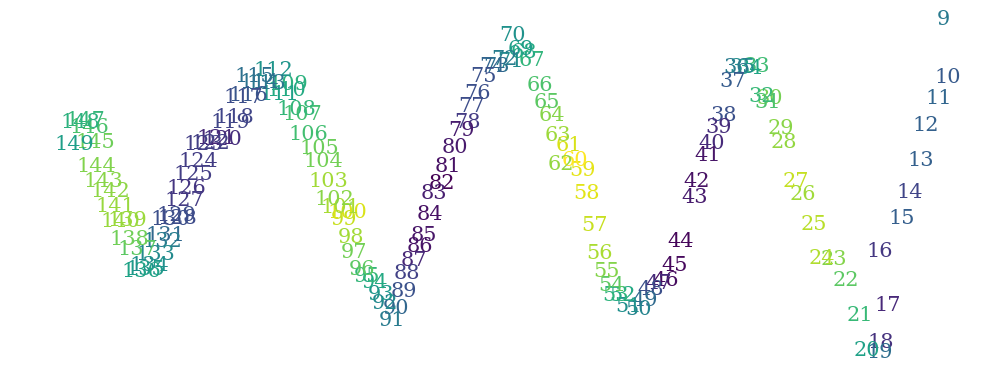

In [11]:
def plot_ax0(Z_emb, ax, x_pc=0, y_pc=1, title="Z"):
    cmap = "viridis"
    import matplotlib as mpl
    Z = np.arange(len(Z_emb))
    Z = Z[9:150]
    labels = Z
    Z_emb = Z_emb[9:150]

    Z = Z_emb[:,2]
    norm = mpl.colors.Normalize(vmin=min(Z), vmax=max(Z))
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    Z = sm.to_rgba(Z)

    plt.sca(ax)
    plt.scatter(Z_emb[:, x_pc], Z_emb[:, y_pc], c=Z, cmap=cmap, s=0)
    from lib.utils import PlottingContext
    PlottingContext.scatter_text(labels, Z_emb[:, x_pc], Z_emb[:, y_pc], colors=Z, ax=plt.gca(), fontsize=15)
    plt.xlabel("PC0"); plt.ylabel("PC1"); plt.title(title)


pca = PCA(n_components=3)
emb_pca = pca.fit_transform(model.emb[1].detach().cpu().numpy())

# plot the embeddings Z and N are the columns
fig, ax = plt.subplots(1, 1, figsize=(10, 4), sharex=True, sharey=True)
# PC1 vs PC0

plot_ax0(emb_pca, ax, title=None)
# PC1 vs PC0
plt.axis('off')
fig.tight_layout(w_pad=0, h_pad=0)
plt.savefig("plots/pca_data.pdf")
plt.show()

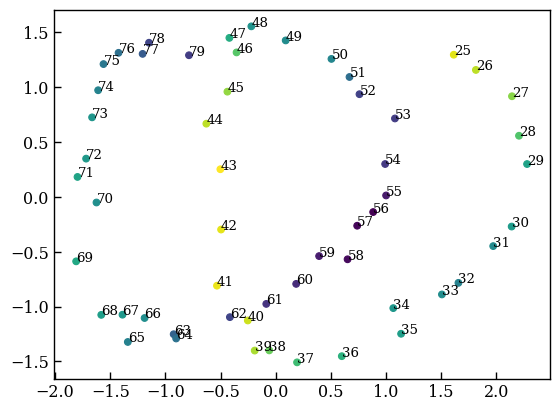

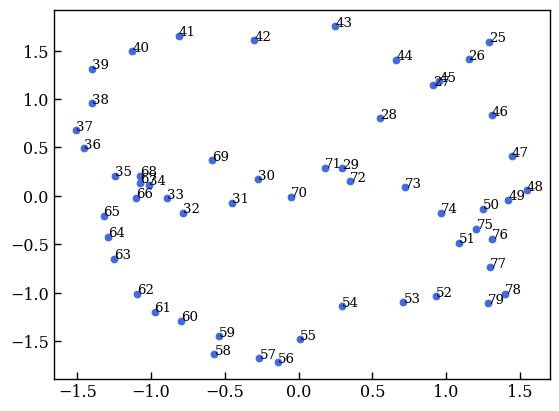

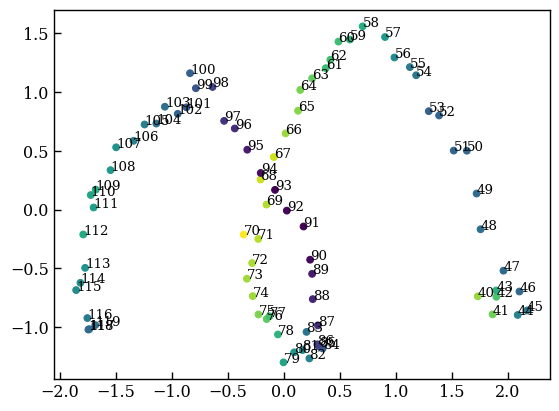

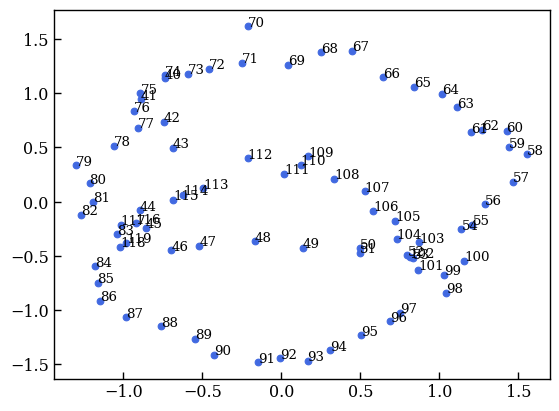

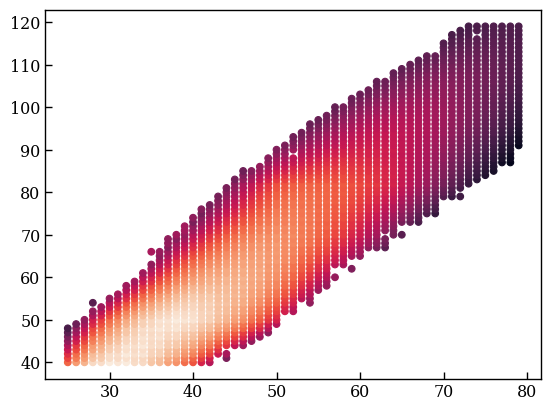

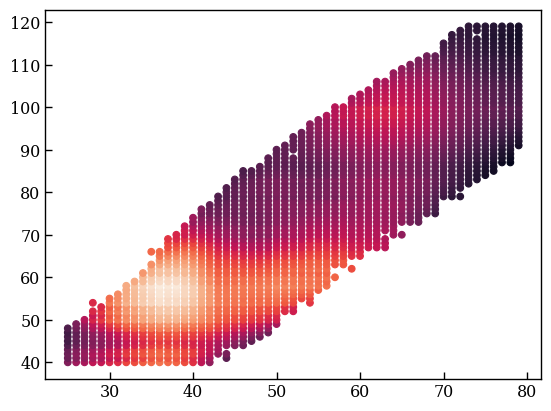

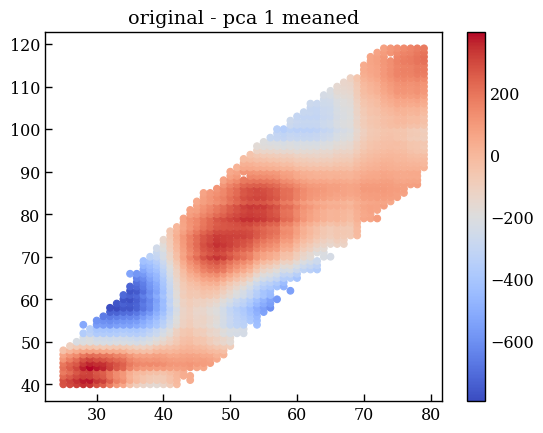

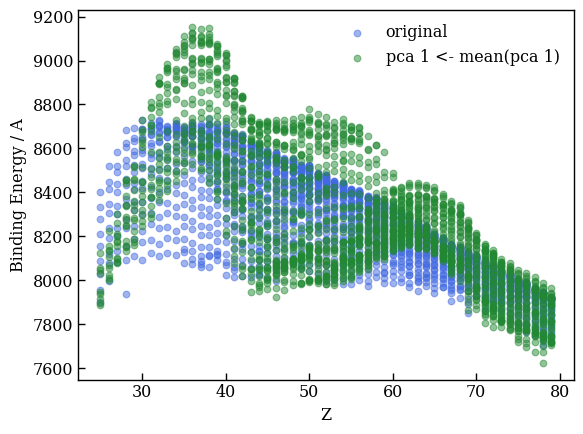

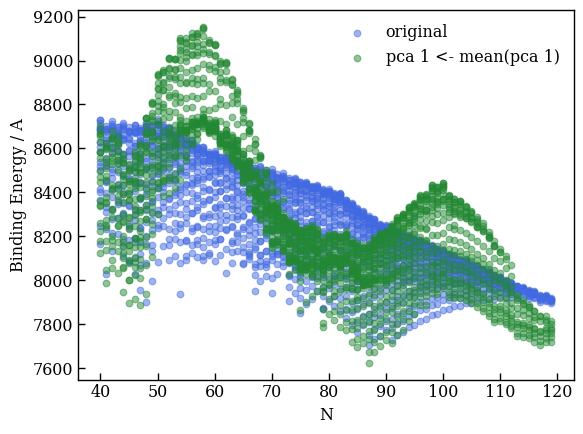

In [12]:
start_z = 25
end_z = 80
pca_z = PCA(n_components=end_z - start_z)
emb_pca_z = pca_z.fit_transform(model.emb[0][start_z:end_z].detach().cpu().numpy())
plt.scatter(emb_pca_z[:, 0], emb_pca_z[:, 1], c=emb_pca_z[:, 2], cmap='viridis')
for i, emb in enumerate(emb_pca_z):
  plt.annotate(i+start_z, emb[:2])
plt.show()

plt.scatter(emb_pca_z[:, 1], emb_pca_z[:, 2])
for i, emb in enumerate(emb_pca_z):
  plt.annotate(i+start_z, emb[[1,2]])
plt.show()

start_n = 40
end_n = 120
pca_n = PCA(n_components=end_n - start_n)
emb_pca_n = pca_n.fit_transform(model.emb[1][start_n:end_n].detach().cpu().numpy())
plt.scatter(emb_pca_n[:, 0], emb_pca_n[:, 1], c=emb_pca_n[:, 2], cmap='viridis')
for i, emb in enumerate(emb_pca_n):
  plt.annotate(i+start_n, emb[:2])
plt.show()

plt.scatter(emb_pca_n[:, 1], emb_pca_n[:, 2])
for i, emb in enumerate(emb_pca_n):
  plt.annotate(i+start_n, emb[[1,2]])
plt.show()

# TODO comment this back in
emb_pca_z[:,[1]] = emb_pca_z[:,[1]].mean(0)
emb_pca_n[:,[1]] = emb_pca_n[:,[1]].mean(0)

model_emb = deepcopy(model)
model_emb.emb[0][start_z:end_z] = torch.tensor(pca_z.inverse_transform(emb_pca_z))
model_emb.emb[1][start_n:end_n] = torch.tensor(pca_n.inverse_transform(emb_pca_n))
model_emb.readout = model.readout

sel = (data.X[:,0] >= start_z) & (data.X[:,0] < end_z) & (data.X[:,1] >= start_n) & (data.X[:,1] < end_n)  & (data.X[:,2] == 0)# & ((data.X[:,0] == 50) | (data.X[:,0] == 60))
X = data.X[sel]
output_emb = model_emb(X) / X.sum(1, keepdim=True)
output = model(X) / X.sum(1, keepdim=True)

plt.scatter(X[:, 0], X[:,1], c=output.numpy())
plt.show()
plt.scatter(X[:, 0], X[:,1], c=output_emb.numpy())
plt.show()

plt.scatter(X[:, 0], X[:,1], c=output.numpy() - output_emb.numpy(), cmap="coolwarm")
plt.colorbar()
plt.title("original - pca 1 meaned")
plt.show()

plt.scatter(X[:, 0], output.detach().cpu().numpy(), label='original', alpha=.5)
plt.scatter(X[:, 0], output_emb.detach().cpu().numpy(), label='pca 1 <- mean(pca 1)', alpha=.5)
plt.xlabel("Z")
plt.ylabel("Binding Energy / A")
plt.legend()
plt.show()

plt.scatter(X[:, 1], output.detach().cpu().numpy(), label='original', alpha=.5)
plt.scatter(X[:, 1], output_emb.detach().cpu().numpy(), label='pca 1 <- mean(pca 1)', alpha=.5)
plt.xlabel("N")
plt.ylabel("Binding Energy / A")
plt.legend()
plt.show()

In [13]:

def find_orthonormal_basis(a):
    """
    Find two orthonormal vectors that are perpendicular to the vector a in PyTorch.
    """
    if a[0] != 0 or a[1] != 0:
        v1 = torch.tensor([-a[1], a[0], 0], dtype=torch.float32)
    else:
        v1 = torch.tensor([0, -a[2], a[1]], dtype=torch.float32)
    v1 = v1 / torch.norm(v1)
    v2 = torch.cross(a, v1)
    return v1, v2

def helix(t, R, F, P, axis, start, phase, final_linear):
    """
    Parametric equations for a 3D spiral (helix) around a specified axis in PyTorch.
    """
    # Normalize the axis
    a = axis / torch.norm(axis)
    
    # Find two orthonormal vectors perpendicular to the axis
    u, v = find_orthonormal_basis(a)

    # Circular motion around the axis
    V_perp = R * (torch.cos(2*torch.pi * F * t + phase)[:, None] * u + torch.sin(2*torch.pi*F * t + phase)[:, None] * v)

    # Movement along the axis
    V_axis = P * t[:, None] * a

    return (V_perp + V_axis + start) @ final_linear


# Toy data generation
# t = torch.linspace(0, 5, len(emb_pca))
# R_true = 1
# F_true = 0.3 * 2 * torch.pi
# P_true = 4
# axis_true = torch.tensor([1., 0., 1.], dtype=torch.float32)  # Arbitrary axis
# start_point = torch.tensor([0., 0., 0.], dtype=torch.float32)  # Arbitrary start point

# Generating the helix data
# data = helix(t, R_true, F_true, P_true, axis_true, start_point)
emb_pca_z = torch.from_numpy(pca_z.transform(model.emb[0][start_z:end_z].detach().cpu().numpy()))
emb_pca_n = torch.from_numpy(pca_n.transform(model.emb[1][start_n:end_n].detach().cpu().numpy()))

def get_spiral_preds(emb_pca):

  # Parameters as PyTorch tensors
  t = torch.linspace(0, 1, len(emb_pca[:,:3]), requires_grad=False)
  R = torch.tensor(1.0, requires_grad=True)  # Radius
  F = torch.tensor(2., requires_grad=True)  # Frequency
  P = torch.tensor(5., requires_grad=True)  # Pitch
  axis = torch.tensor([1.,0.,0.], requires_grad=True, dtype=torch.float32)  # Axis of the spiral
  starto = torch.tensor([-3.,-1,0.], requires_grad=True, dtype=torch.float32)  # Start point of the spiral
  phase = torch.tensor(0.5, requires_grad=True)  # Phase shift of the spiral
  final_linear = torch.eye(3, requires_grad=True, dtype=torch.float32)

  # # Optimizer
  optimizer = torch.optim.Adam([R, F, P, axis, starto, final_linear], lr=0.01)

  # Loss function
  def loss_fn(predicted, target):
      return ((predicted - target)**2).mean()

  # Training loop
  epochs = 3000
  for epoch in range(epochs):
      optimizer.zero_grad()
      predicted = helix(t, R, F, P, axis, starto, phase, final_linear)
      loss = loss_fn(predicted, emb_pca[:,:3])
      loss.backward()
      optimizer.step()

      if (epoch+1) % 100 == 0:
          print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}', end="\r")

  return predicted, {'t':t, 'R': R, 'F': F, 'P': P, 'axis': axis, 'start': starto, 'phase': phase, 'final_linear': final_linear}

predicted_n, spiral_n_params = get_spiral_preds(emb_pca_n)
predicted_z, spiral_z_params = get_spiral_preds(emb_pca_z)
diff_n = emb_pca_n[:, :3] - predicted_n
diff_z = emb_pca_z[:, :3] - predicted_z


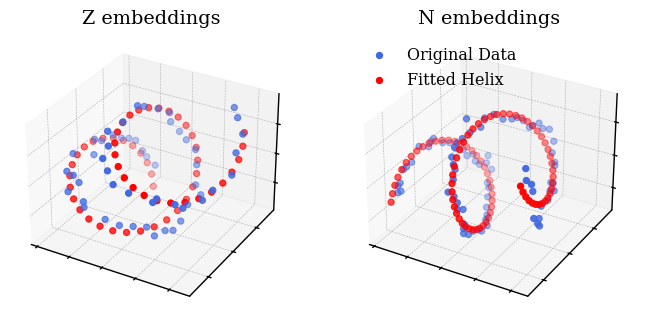

In [14]:
# Plotting the results
fig, axes = plt.subplots(1, 2, figsize=(8, 5), subplot_kw={'projection': '3d'})
ax = axes[0]
predicted_z = helix(**spiral_z_params).detach().numpy()
ax.scatter(emb_pca_z[:, 0], emb_pca_z[:, 1], emb_pca_z[:, 2], label='Original Data')
ax.scatter(predicted_z[:, 0], predicted_z[:, 1], predicted_z[:, 2], label='Fitted Helix', c="r")
ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([])
ax.set_title("Z embeddings")

ax = axes[1]
predicted_n = helix(**spiral_n_params).detach().numpy()
ax.scatter(emb_pca_n[:, 0], emb_pca_n[:, 1], emb_pca_n[:, 2], label='Original Data')
ax.scatter(predicted_n[:, 0], predicted_n[:, 1], predicted_n[:, 2], label='Fitted Helix', c="r")
ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([])
ax.set_title("N embeddings")
plt.legend(loc="upper left")
plt.savefig("plots/spiral_data_fits.pdf")


In [15]:
from copy import deepcopy
with torch.no_grad():
  model_spiral = deepcopy(model)
  model_spiral.readout = model.readout

  spiral_embs_n = emb_pca_n.clone().numpy()
  spiral_embs_n[:, :3] = helix(**spiral_n_params) + diff_n
  # spiral_embs_n[:, :3] += torch.randn(spiral_embs_n[:, :3].shape).numpy()*.2
  spiral_embs_n = pca_n.inverse_transform(spiral_embs_n)
  spiral_embs_n = torch.tensor(spiral_embs_n, device=args.DEV).float()
  model_spiral.emb[1][start_n:end_n] = spiral_embs_n

  spiral_embs_z = emb_pca_z.clone().numpy()
  spiral_embs_z[:, :3] = helix(**spiral_z_params) + diff_z
  # spiral_embs_z[:, :3] += torch.randn(spiral_embs_z[:, :3].shape).numpy()*.2
  spiral_embs_z = pca_z.inverse_transform(spiral_embs_z)
  spiral_embs_z = torch.tensor(spiral_embs_z, device=args.DEV).float()
  model_spiral.emb[0][start_z:end_z] = spiral_embs_z

In [16]:
@torch.no_grad()
def get_spiral_outputs(params_n, params_z):
    helix_n = helix(**params_n).cpu().numpy() + diff_n.numpy()
    helix_z = helix(**params_z).cpu().numpy() + diff_z.numpy()

    model_spiral = deepcopy(model)
    model_spiral.readout = model.readout

    spiral_embs_n = emb_pca_n.clone().numpy()
    spiral_embs_n[:, :3] = helix_n
    spiral_embs_n = pca_n.inverse_transform(spiral_embs_n)
    spiral_embs_n = torch.tensor(spiral_embs_n, device=args.DEV).float()
    model_spiral.emb[1][start_n:end_n] = spiral_embs_n

    spiral_embs_z = emb_pca_z.clone().numpy()
    spiral_embs_z[:, :3] = helix_z
    spiral_embs_z = pca_z.inverse_transform(spiral_embs_z)
    spiral_embs_z = torch.tensor(spiral_embs_z, device=args.DEV).float()
    model_spiral.emb[0][start_z:end_z] = spiral_embs_z
    
    output_spiral = model_spiral(X) / X.sum(1, keepdim=True)
    return output_spiral

# plot the output as a function of spiral parameters
def plot_output_with_params(params_n : dict, params_z : dict, savepath=None, mod="R", val=1):
  with torch.no_grad():
    output_spiral = get_spiral_outputs(params_n, params_z)  
    output_default = model(X) / X.sum(1, keepdim=True)

    # plt.title("fitted spiral vs default")
    # plt.scatter(X[:, 0], X[:,1], c=output_spiral.numpy() - output_default.numpy(), cmap="coolwarm")
    # plt.colorbar()
    # plt.show()
    
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(131, projection='3d')
    ax.scatter(predicted_n[:, 0], predicted_n[:, 1], predicted_n[:, 2], label='default')
    ax.scatter(*helix(**params_n)[:,:3].T, label="modified", color="r")
    ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([])
    plt.legend()
    plt.title(f"Mod: {val} x {mod}")

    sel_z = X[:,1] == 80# (X[:,1] > 82) & (X[:,1] < 87)
    # sel_z = (X[:,1] > 82) & (X[:,1] < 87)
    # sel_z = X[:,1] > 0
    ax = fig.add_subplot(132)
    ax.plot(X[:,0][sel_z], output_default[sel_z].detach().cpu().numpy(), "-o", label='default')
    ax.plot(X[:,0][sel_z], output_spiral[sel_z].detach().cpu().numpy(), "-o", label='modified', color="r")
    ax.set_xlabel("Z")
    ax.set_ylabel("Output / A")
    ax.set_yticklabels([])
    ax.set_title("N=80")

    sel_n = X[:,0] == 50# (X[:,0] > 50) & (X[:,0] < 55)
    # sel_n = (X[:,0] > 50) & (X[:,0] < 55)
    # sel_n = X[:,0] > 0
    ax = fig.add_subplot(133)
    ax.plot(X[:,1][sel_n], output_default[sel_n].detach().cpu().numpy(), "-o", label='default')
    ax.plot(X[:,1][sel_n], output_spiral[sel_n].detach().cpu().numpy(), "-o", label='modified', color="r")
    ax.set_xlabel("N")
    ax.set_ylabel("Output / A")
    ax.set_yticklabels([])
    ax.set_title("Z=50")
    plt.legend()
    if savepath:
      plt.savefig(savepath)
    else:
      plt.show()


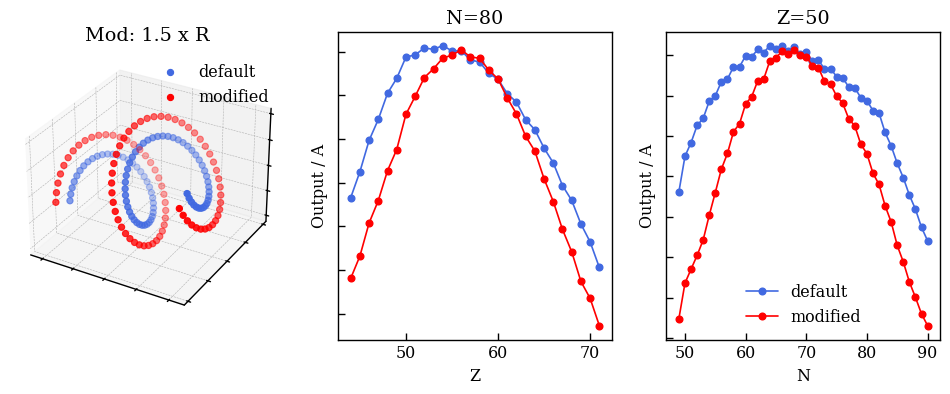

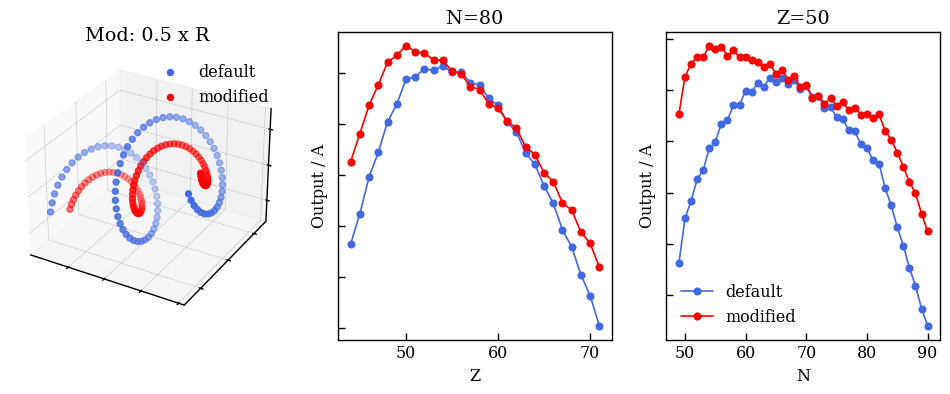

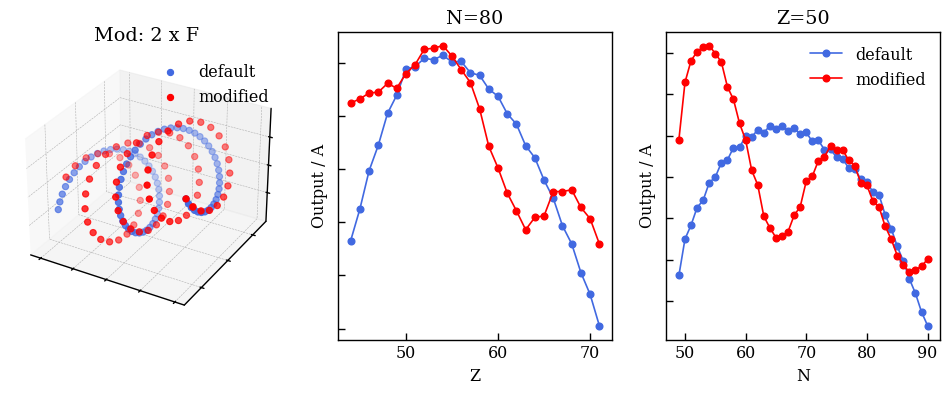

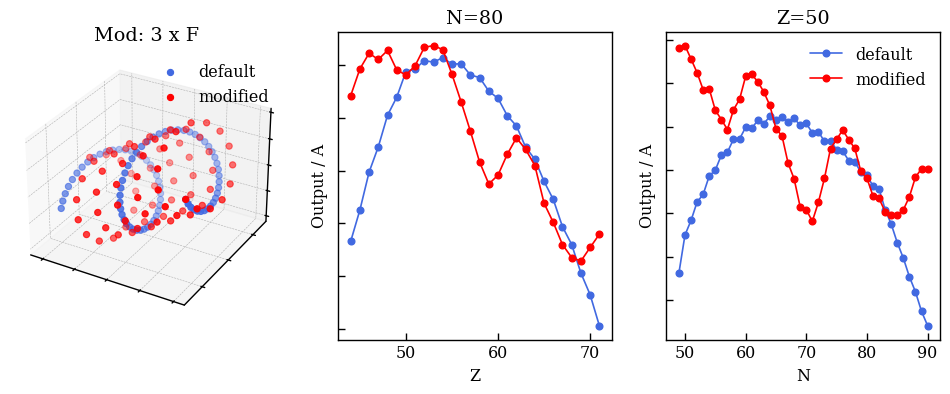

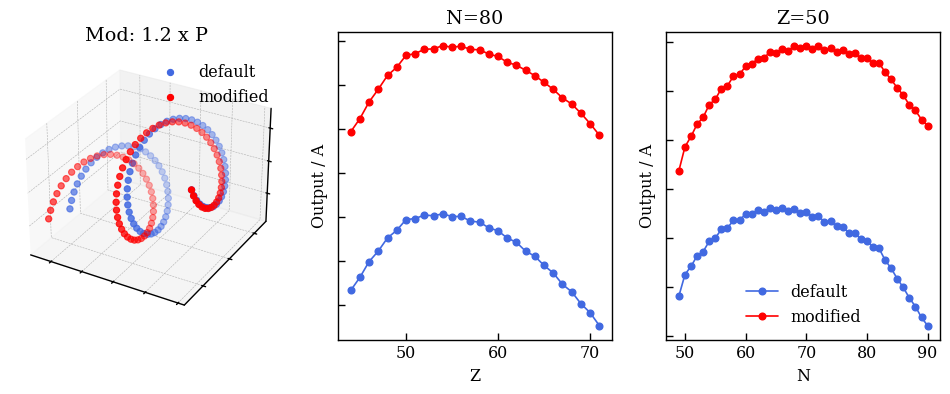

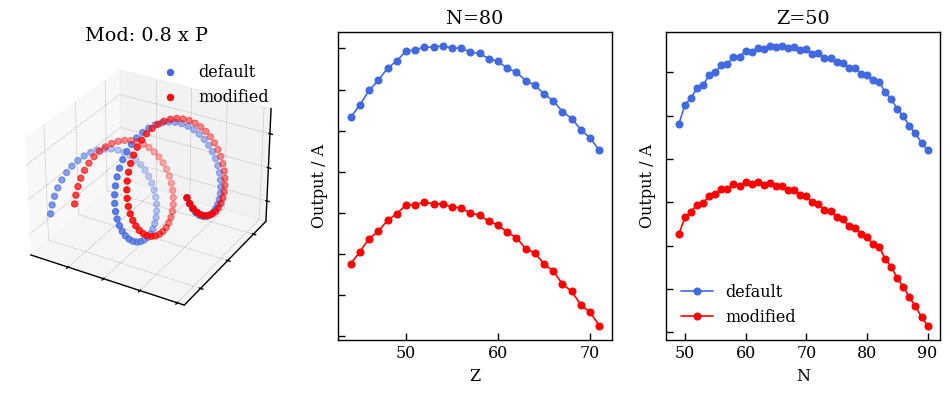

In [17]:
with torch.no_grad():

  for name, M in [("R", 1.5),("R", .5), ("F", 2),("F", 3), ("P", 1.2), ("P", .8)]:
    new_params = {"params_n": deepcopy(spiral_n_params), "params_z": deepcopy(spiral_z_params)}

    new_params["params_n"][name] *= M
    new_params["params_z"][name] *= M
    
    plot_output_with_params(**new_params, savepath = f"plots/spiral_modded_data_{name}_{M}.pdf", mod=name, val=M)